![EuroSAT](https://github.com/phelber/EuroSAT/blob/master/eurosat_overview_small.jpg?raw=true "EuroSat")

In [1]:
# Version Check
import sys
import tensorflow as tf
import tensorflow_datasets as tfds
import PIL
import pandas as pd
import numpy as np
import scipy
print("python", sys.version)
print("tensorflow", tf.__version__)
print("tensorflow-datasets", tfds.__version__)
print("Pillow", PIL.__version__)
print("pandas", pd.__version__)
print("numpy", np.__version__)
print("scipy", scipy.__version__)
print()
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Built with GPU support:", tf.test.is_built_with_gpu_support())

python 3.8.0 (default, Nov  6 2019, 16:00:02) [MSC v.1916 64 bit (AMD64)]
tensorflow 2.6.2
tensorflow-datasets 4.4.0
Pillow 8.3.2
pandas 1.3.3
numpy 1.19.5
scipy 1.7.1

Num GPUs Available: 1
Built with CUDA: True
Built with GPU support: True


## Data Prep

In [2]:
import json
import matplotlib.pylab as plt

In [3]:
DATA_DIR = "dataset/"  

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                        shuffle_files=True, 
                                        as_supervised=True,
                                        with_info=True,
                                        data_dir=DATA_DIR)

In [4]:
print(train_ds)
print(valid_ds)

<_OptionsDataset shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>


In [5]:
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='dataset/eurosat\\rgb\\2.0.0',
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    di

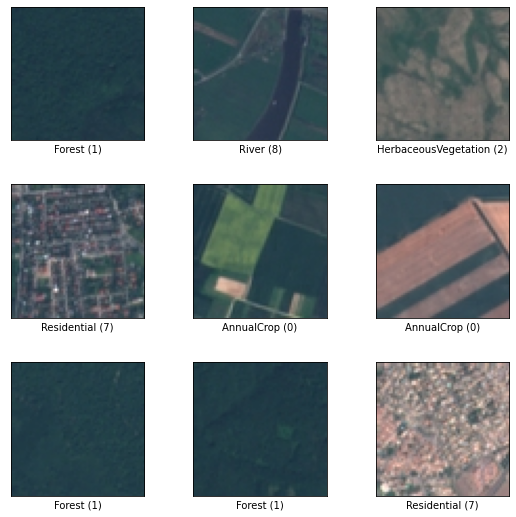

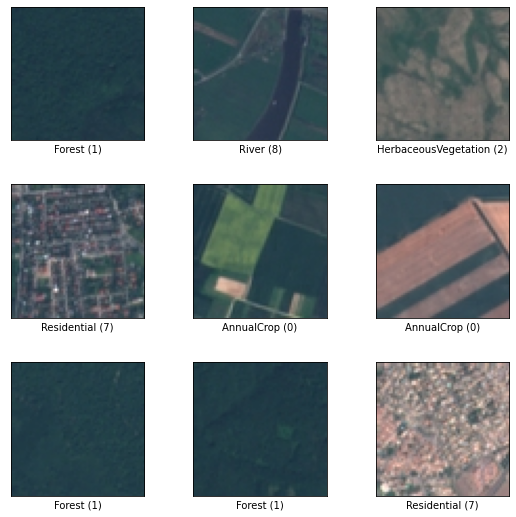

In [6]:
tfds.show_examples(train_ds, info)

,image,label
0,,8 (River)
1,,5 (Pasture)
2,,2 (HerbaceousVegetation)
3,,9 (SeaLake)
4,,3 (Highway)
5,,7 (Residential)
6,,1 (Forest)
7,,0 (AnnualCrop)
8,,9 (SeaLake)
9,,0 (AnnualCrop)

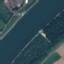
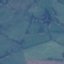
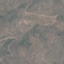
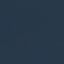
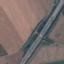
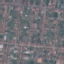
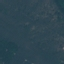
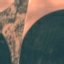
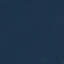
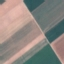

In [7]:
tfds.as_dataframe(valid_ds.take(10), info)

In [8]:
info.features

FeaturesDict({
    'filename': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [9]:
NUM_CLASSES = info.features['label'].num_classes
NUM_CLASSES

10

In [10]:
for i in range(10):
    print(i, info.features['label'].int2str(i))

0 AnnualCrop
1 Forest
2 HerbaceousVegetation
3 Highway
4 Industrial
5 Pasture
6 PermanentCrop
7 Residential
8 River
9 SeaLake


## Preprocessing

In [11]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # 0~1 normalization, conversion to float32
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Modeling

In [13]:
# Sequential API

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model():
    
    model = Sequential([
        
        # Convolution
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Classifer output
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

model = build_model()

## Compile & Fit

In [14]:
# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

# Fit
history = model.fit(train_data, validation_data=valid_data, epochs=50)

Epoch 1/50
338/338 [==============================] - 10s 10ms/step - loss: 1.6548 - acc: 0.4153 - val_loss: 1.6185 - val_acc: 0.3885
Epoch 2/50
338/338 [==============================] - 3s 9ms/step - loss: 1.2751 - acc: 0.5479 - val_loss: 0.9999 - val_acc: 0.6489
Epoch 3/50
338/338 [==============================] - 3s 9ms/step - loss: 1.0914 - acc: 0.6131 - val_loss: 0.7685 - val_acc: 0.7363
Epoch 4/50
338/338 [==============================] - 3s 9ms/step - loss: 0.9351 - acc: 0.6644 - val_loss: 0.6588 - val_acc: 0.7854
Epoch 5/50
338/338 [==============================] - 3s 9ms/step - loss: 0.8340 - acc: 0.7000 - val_loss: 0.6667 - val_acc: 0.7815
Epoch 6/50
338/338 [==============================] - 3s 9ms/step - loss: 0.7628 - acc: 0.7294 - val_loss: 0.6204 - val_acc: 0.7917
Epoch 7/50
338/338 [==============================] - 3s 9ms/step - loss: 0.7047 - acc: 0.7546 - val_loss: 0.5135 - val_acc: 0.8352
Epoch 8/50
338/338 [==============================] - 3s 10ms/step - loss:

## Visualiztion

In [67]:
model.evaluate(valid_data)  # loss, acc

85/85 [==============================] - 0s 4ms/step - loss: 0.5436 - acc: 0.8772


[0.5435709953308105, 0.8772222399711609]

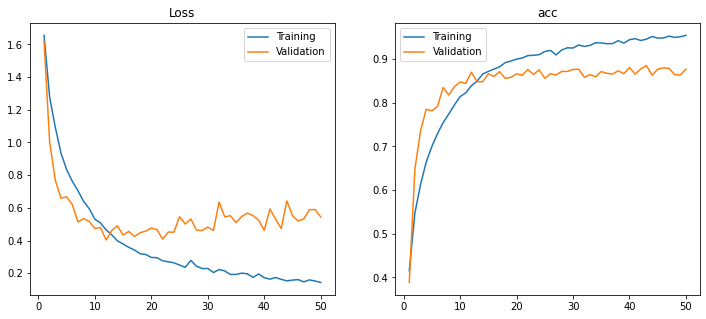

In [19]:
# Fit history visualization

import matplotlib.pylab as plt

def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['acc'], history.history['val_acc']

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    ax1.plot(range(1, epoch + 1), loss, label='Training')
    ax1.plot(range(1, epoch + 1), val_loss, label='Validation')
    ax1.legend(loc='best')
    ax1.set_title('Loss')

    ax2.plot(range(1, epoch + 1), acc, label='Training')
    ax2.plot(range(1, epoch + 1), val_acc, label='Validation')
    ax2.legend(loc='best')
    ax2.set_title('acc')

    plt.show()

plot_loss_acc(history, 50)

# Even with BatchNormalization and Dropout, the model seems to overfit after the 10-ish th epoch.

## Data Augmentation

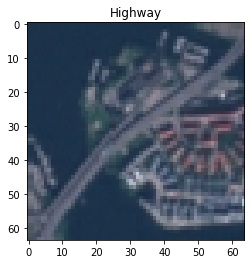

In [42]:
# Sample Image

image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features['label'].int2str(label))

plt.show()

In [43]:
# Original / Augmented Visualization

def plot_augmentation(original, augmented):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    axes[0].imshow(original)
    axes[0].set_title('Original')
    
    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')
    
    plt.show()

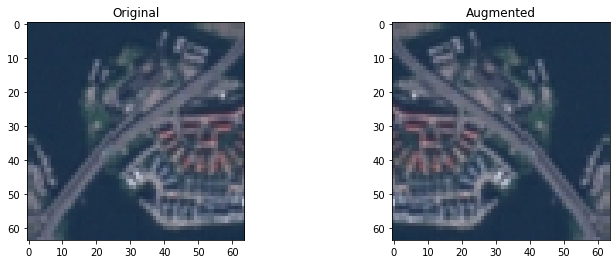

In [46]:
# Flip left-right
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

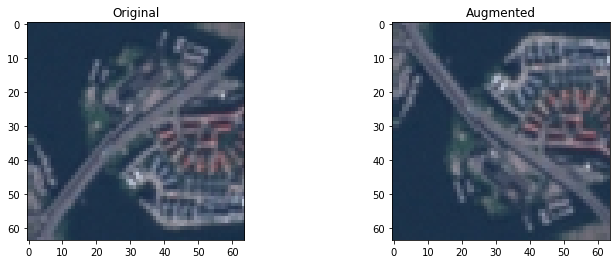

In [47]:
# Flip up-down
up_flip = tf.image.flip_up_down(image)
plot_augmentation(image, up_flip)

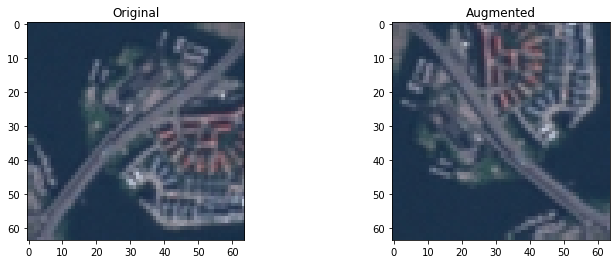

In [48]:
# Rotation
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

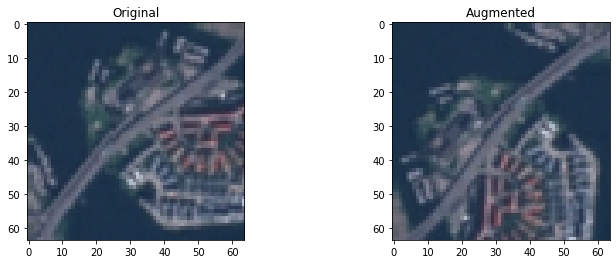

In [49]:
# Transpose
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

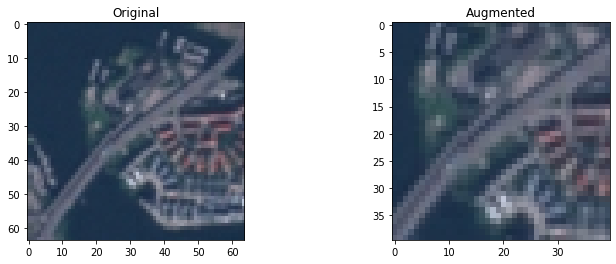

In [50]:
# Crop 1
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

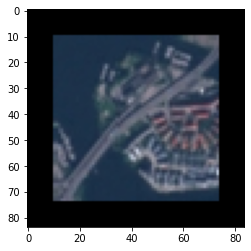

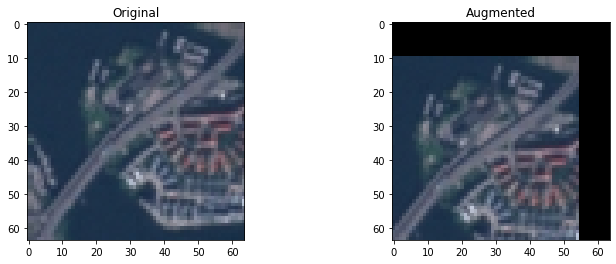

In [52]:
# Crop 2
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20)
plt.imshow(img)

crop2 = tf.image.random_crop(img, size=(64, 64, 3))
plot_augmentation(image, crop2)

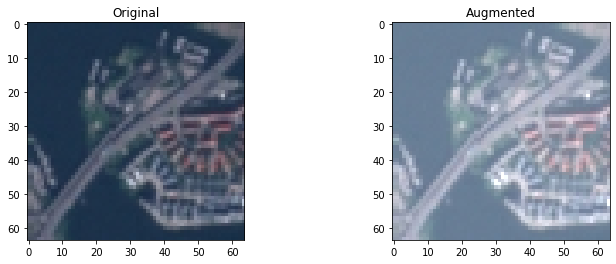

In [53]:
# Brightness

brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

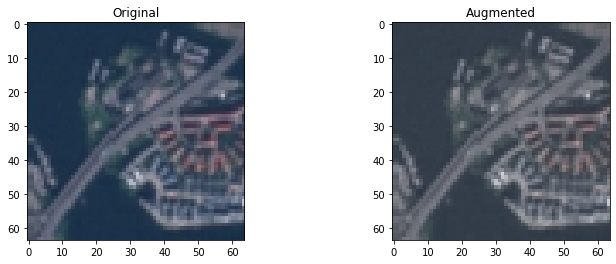

In [55]:
# Saturation
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

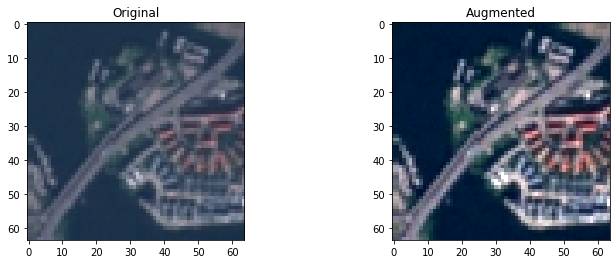

In [57]:
# Contrast
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

In [64]:
# Image Augmentation Preprocessing

def data_augmentation(image, label):
    
    image = tf.image.random_flip_left_right(image)            # Random flip left-right
    image = tf.image.random_flip_up_down(image)               # Random flip up-down
    image = tf.image.random_brightness(image, max_delta=0.3)  # Random brightness
    image = tf.image.random_crop(image, size=[64, 64, 3])     # Random crop
    
    image = tf.cast(image, tf.float32) / 255.0                # 0~1 Normalization
    
    return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

print(train_aug)
print(valid_aug)

<PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int64)>


In [65]:
# Modeling
aug_model = build_model()

# Compile
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

# Fit
aug_history = aug_model.fit(train_aug, validation_data=valid_aug, epochs=50)

Epoch 1/50
338/338 [==============================] - 5s 14ms/step - loss: 1.8864 - acc: 0.2909 - val_loss: 1.7827 - val_acc: 0.3498
Epoch 2/50
338/338 [==============================] - 3s 10ms/step - loss: 1.6141 - acc: 0.3698 - val_loss: 1.3473 - val_acc: 0.5028
Epoch 3/50
338/338 [==============================] - 3s 9ms/step - loss: 1.4555 - acc: 0.4296 - val_loss: 1.2230 - val_acc: 0.5324
Epoch 4/50
338/338 [==============================] - 3s 10ms/step - loss: 1.3720 - acc: 0.4682 - val_loss: 1.1599 - val_acc: 0.5815
Epoch 5/50
338/338 [==============================] - 3s 10ms/step - loss: 1.3054 - acc: 0.4910 - val_loss: 1.1431 - val_acc: 0.5757
Epoch 6/50
338/338 [==============================] - 3s 9ms/step - loss: 1.2590 - acc: 0.5182 - val_loss: 1.1135 - val_acc: 0.6020
Epoch 7/50
338/338 [==============================] - 3s 10ms/step - loss: 1.2175 - acc: 0.5358 - val_loss: 1.0378 - val_acc: 0.6470
Epoch 8/50
338/338 [==============================] - 3s 9ms/step - los

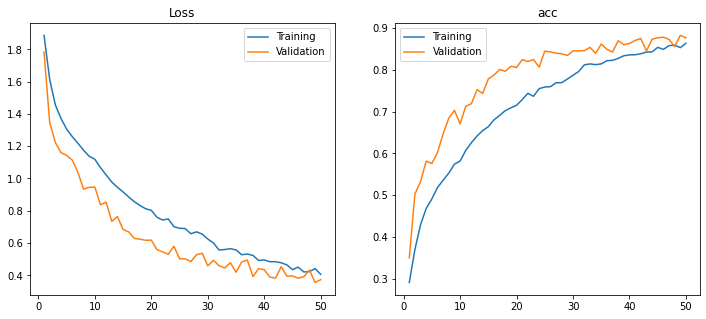

In [73]:
# Fit history visualization

plot_loss_acc(aug_history, 50)

# With data augmentation, the much of overfit issue has seemingly been resolved.

# The validation loss is still lower than training loss at the last epoch, so there is a possiblity of further improvement 
# with more epochs.

In [78]:
# Fit with more epochs (epochs=70)

# Modeling
aug_model = build_model()

# Compile
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

# Fit
aug_history_2 = aug_model.fit(train_aug, validation_data=valid_aug, epochs=70)

Epoch 1/70
338/338 [==============================] - 4s 9ms/step - loss: 1.8717 - acc: 0.3007 - val_loss: 1.6575 - val_acc: 0.3643
Epoch 2/70
338/338 [==============================] - 3s 9ms/step - loss: 1.5268 - acc: 0.4123 - val_loss: 1.3941 - val_acc: 0.4987
Epoch 3/70
338/338 [==============================] - 3s 9ms/step - loss: 1.3846 - acc: 0.4750 - val_loss: 1.2113 - val_acc: 0.5391
Epoch 4/70
338/338 [==============================] - 3s 9ms/step - loss: 1.2774 - acc: 0.5226 - val_loss: 1.0467 - val_acc: 0.6487
Epoch 5/70
338/338 [==============================] - 3s 9ms/step - loss: 1.1878 - acc: 0.5690 - val_loss: 1.0247 - val_acc: 0.6594
Epoch 6/70
338/338 [==============================] - 3s 9ms/step - loss: 1.1057 - acc: 0.6000 - val_loss: 0.9246 - val_acc: 0.6669
Epoch 7/70
338/338 [==============================] - 3s 9ms/step - loss: 1.0370 - acc: 0.6270 - val_loss: 0.7806 - val_acc: 0.7250
Epoch 8/70
338/338 [==============================] - 3s 9ms/step - loss: 0.

338/338 [==============================] - 3s 9ms/step - loss: 0.3248 - acc: 0.8941 - val_loss: 0.3558 - val_acc: 0.8959
Epoch 63/70
338/338 [==============================] - 3s 9ms/step - loss: 0.3355 - acc: 0.8909 - val_loss: 0.3655 - val_acc: 0.8906
Epoch 64/70
338/338 [==============================] - 3s 9ms/step - loss: 0.3188 - acc: 0.8940 - val_loss: 0.3655 - val_acc: 0.8770
Epoch 65/70
338/338 [==============================] - 3s 9ms/step - loss: 0.3204 - acc: 0.8956 - val_loss: 0.3570 - val_acc: 0.8930
Epoch 66/70
338/338 [==============================] - 3s 9ms/step - loss: 0.3076 - acc: 0.8982 - val_loss: 0.3416 - val_acc: 0.8904
Epoch 67/70
338/338 [==============================] - 3s 9ms/step - loss: 0.3180 - acc: 0.8961 - val_loss: 0.3328 - val_acc: 0.8913
Epoch 68/70
338/338 [==============================] - 3s 9ms/step - loss: 0.3111 - acc: 0.9003 - val_loss: 0.3800 - val_acc: 0.8896
Epoch 69/70
338/338 [==============================] - 3s 9ms/step - loss: 0.2866

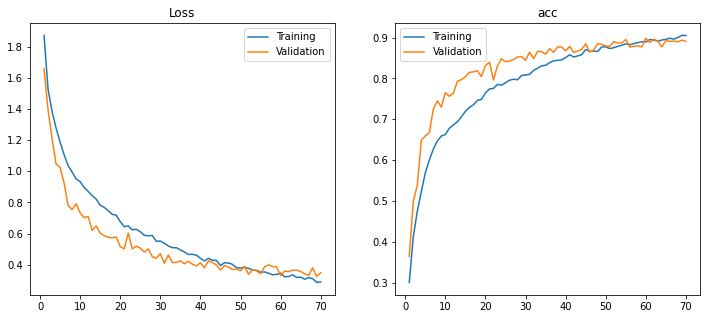

In [80]:
# Fit history visualization

plot_loss_acc(aug_history_2, 70)

# After 50ish-th epoch, the validation loss is minimized.

## Transfer Model: ResNet

94683136/94668760 [==============================] - 2s 0us/step


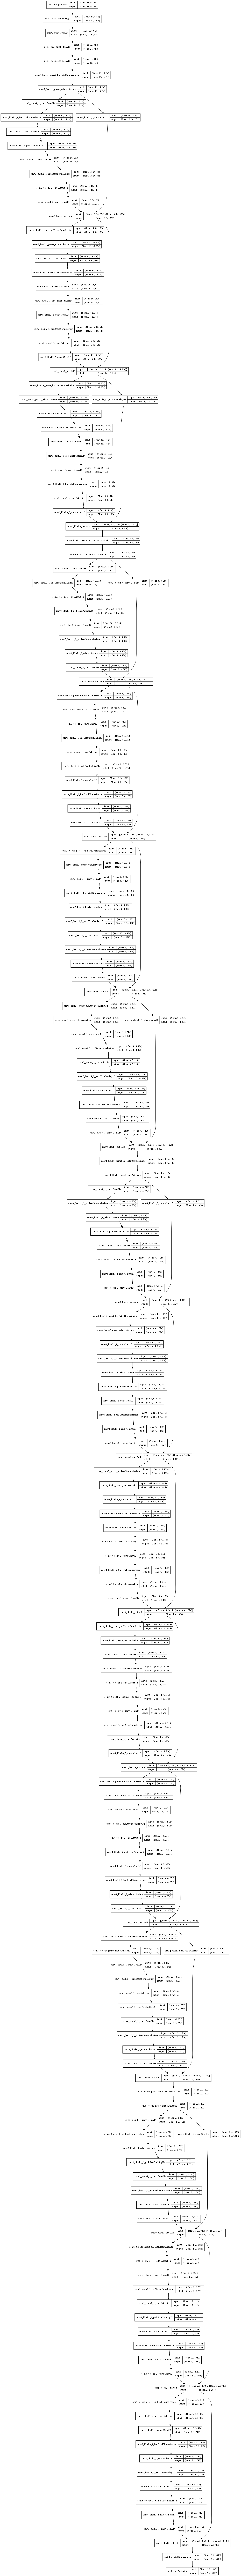

In [81]:
# Transfer learning, w/ weights
from tensorflow.keras.applications import ResNet50V2
pre_trained_base = ResNet50V2(include_top=False, weights='imagenet', input_shape=(64, 64, 3))

# Weights update=False
pre_trained_base.trainable=False

# Model structure visualization
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

In [82]:
pre_trained_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [84]:
# Adding classifer at the top layers(=output layers)

def build_transfer_classifier():
    
    model = Sequential([
        pre_trained_base,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

tc_model = build_transfer_classifier()
tc_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2, 2, 2048)        23564800  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)               

In [85]:
# Compile
tc_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

# Fit
tc_history = tc_model.fit(train_aug, validation_data=valid_aug, epochs=50)

Epoch 1/50
338/338 [==============================] - 14s 33ms/step - loss: 1.0353 - acc: 0.6635 - val_loss: 0.6004 - val_acc: 0.7989
Epoch 2/50
338/338 [==============================] - 10s 28ms/step - loss: 0.7282 - acc: 0.7661 - val_loss: 0.5508 - val_acc: 0.8189
Epoch 3/50
338/338 [==============================] - 10s 29ms/step - loss: 0.6525 - acc: 0.7889 - val_loss: 0.5134 - val_acc: 0.8302
Epoch 4/50
338/338 [==============================] - 10s 30ms/step - loss: 0.5983 - acc: 0.8050 - val_loss: 0.4751 - val_acc: 0.8385
Epoch 5/50
338/338 [==============================] - 10s 29ms/step - loss: 0.5656 - acc: 0.8164 - val_loss: 0.4636 - val_acc: 0.8407
Epoch 6/50
338/338 [==============================] - 10s 29ms/step - loss: 0.5462 - acc: 0.8224 - val_loss: 0.4503 - val_acc: 0.8476
Epoch 7/50
338/338 [==============================] - 10s 30ms/step - loss: 0.5203 - acc: 0.8296 - val_loss: 0.4515 - val_acc: 0.8480
Epoch 8/50
338/338 [==============================] - 10s 29ms

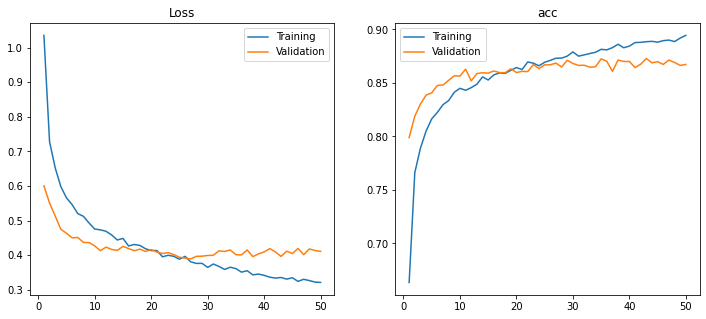

In [86]:
# Fit history visualization

plot_loss_acc(tc_history, 50)

# With pre-trained weight, the accrucay is high at 0.8 even from the beginning.
# The loss reaches its minimum at earlier epoch.

In [87]:
# Transfer learning, without pre-trained weights
from tensorflow.keras.applications import ResNet50V2
pre_trained_base = ResNet50V2(include_top=False, weights=None, input_shape=(64, 64, 3))  # weights=None

tc_model_2 = build_transfer_classifier()

# Compile
tc_model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

# Fit
tc_history_2 = tc_model_2.fit(train_aug, validation_data=valid_aug, epochs=50)

Epoch 1/50
338/338 [==============================] - 29s 75ms/step - loss: 1.8898 - acc: 0.2825 - val_loss: 2.9748 - val_acc: 0.1394
Epoch 2/50
338/338 [==============================] - 24s 71ms/step - loss: 1.6673 - acc: 0.3629 - val_loss: 12.8116 - val_acc: 0.1000
Epoch 3/50
338/338 [==============================] - 26s 78ms/step - loss: 1.5233 - acc: 0.4159 - val_loss: 1.4339 - val_acc: 0.4783
Epoch 4/50
338/338 [==============================] - 27s 80ms/step - loss: 1.4868 - acc: 0.4220 - val_loss: 2.3805 - val_acc: 0.2857
Epoch 5/50
338/338 [==============================] - 25s 73ms/step - loss: 1.3963 - acc: 0.4765 - val_loss: 3.9663 - val_acc: 0.1087
Epoch 6/50
338/338 [==============================] - 25s 74ms/step - loss: 1.4070 - acc: 0.4796 - val_loss: 4.0417 - val_acc: 0.3098
Epoch 7/50
338/338 [==============================] - 24s 70ms/step - loss: 1.3436 - acc: 0.5116 - val_loss: 2.1245 - val_acc: 0.3683
Epoch 8/50
338/338 [==============================] - 24s 70m

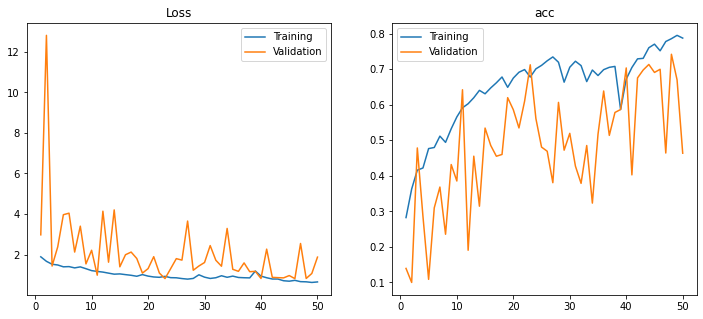

In [89]:
# Fit history visualization

plot_loss_acc(tc_history_2, 50)

# Without pre-trained weights, the time it takes to fit the model is much longer, since it has to update all the weights. 
# Fluctuations in the validation loss and accurcay are obserbed.